In [1]:
# import the necessary packages

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import pandas as pd
import os
import time
from sklearn.metrics import roc_curve, auc 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Check data

In [2]:
train_dir = "../data/train"

CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common-Chickweed', 'Common-wheat', 'Fat-Hen', 'Loose-Silky-bent',
              'Maize', 'Scentless-Mayweed', 'Shepherds-Purse', 'Small-flowered-Cranesbill', 'Sugar-beet']

# check numbers of categories
NumCatergories = len(CATEGORIES)
print("Numbers of categories:", NumCatergories)

# check numbers of images
for category in CATEGORIES:
    print('{}: {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

# creat a dataframe including filename_path, catagory and id
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['../data/train/{}/{}'.format(category, file), category, category_id])
        
train = pd.DataFrame(train, columns=['file', 'category','category_id'])
print("The shape of train: ", train.shape)
train.head(4)


Numbers of categories: 12
Black-grass: 95 images
Charlock: 147 images
Cleavers: 111 images
Common-Chickweed: 218 images
Common-wheat: 70 images
Fat-Hen: 187 images
Loose-Silky-bent: 228 images
Maize: 80 images
Scentless-Mayweed: 185 images
Shepherds-Purse: 74 images
Small-flowered-Cranesbill: 180 images
Sugar-beet: 135 images
The shape of train:  (1710, 3)


,file,category,category_id
0,../data/train/Black-grass/4a3b96198.png,Black-grass,0
1,../data/train/Black-grass/a53088ca0.png,Black-grass,0
2,../data/train/Black-grass/ab479d343.png,Black-grass,0
3,../data/train/Black-grass/d3e69adad.png,Black-grass,0


# Show sample pictures

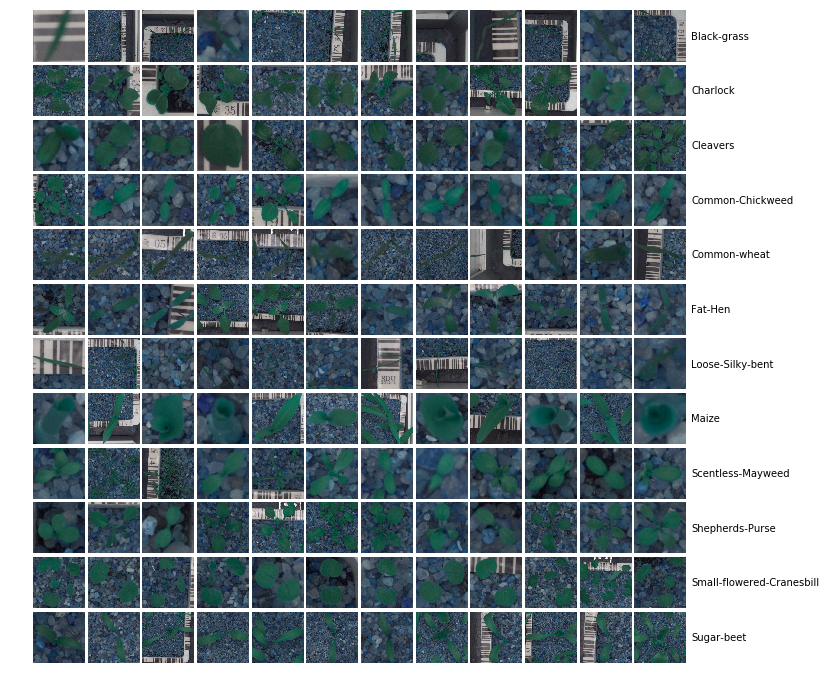

In [3]:
def read_img(filepath, size = (224,224)):
    img = cv2.imread(filepath)
    img = cv2.resize(img, size)
    return img

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, figsize=(NumCatergories, NumCatergories))
grid = ImageGrid(fig, 111, nrows_ncols=(NumCatergories, NumCatergories), axes_pad=0.05)

i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NumCatergories]:
        ax = grid[i]
        img = read_img(filepath)
        ax.imshow(img)
        ax.axis('off')
        if i % NumCatergories == NumCatergories - 1:
            ax.text(250, 112, filepath.split('/')[3], verticalalignment='center')
        i += 1

plt.show()

# Define pre-processing function

In [4]:
def extract_BGR_histogram(image):
    """extract a 3D color histogram from the BGR color space using
    the supplied number of `bins` per channel"""
    Hist = []
    for i in range(3):
        hist = cv2.calcHist([image],[i],None,[128],[0,256])
        Hist = np.append(Hist, hist) 

    # return the flattened histogram as the feature vector
    return Hist.flatten()

def extract_HSV_histogram(image):
    """extract a 3D color histogram from the HSV color space using
    the supplied number of `bins` per channel"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    Hist = []
    for i in range(3):
        hist = cv2.calcHist([hsv],[i],None,[128],[0,256])
        Hist = np.append(Hist, hist) 

    # return the flattened histogram as the feature vector
    return Hist.flatten()


def extract_HLS_histogram(image):
    """extract a 3D color histogram from the HLS color space using
    the supplied number of `bins` per channel"""
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    Hist = []
    for i in range(3):
        hist = cv2.calcHist([hls],[i],None,[128],[0,256])
        Hist = np.append(Hist, hist) 

    # return the flattened histogram as the feature vector
    return Hist.flatten()


def create_mask_for_plant(image):
    """create a mask for the plants image"""
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask


def segment_plant(image):
    """segement out the plants images using the mask"""
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output


def sharpen_image(image):
    """sharpen image"""
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

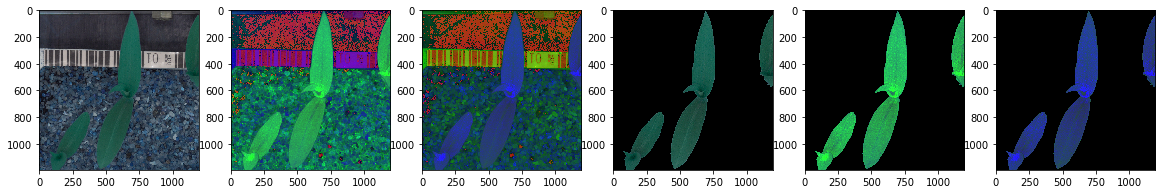

In [7]:
# read full images
img_eg = cv2.imread('../data/train/Maize/00a18f05e.png')
hsv_eg = cv2.cvtColor(img_eg, cv2.COLOR_BGR2HSV)
hls_eg = cv2.cvtColor(img_eg,cv2.COLOR_BGR2HLS)

# mask out images
image_segmented = segment_plant(img_eg)
image_segmented_hls = cv2.cvtColor(image_segmented,cv2.COLOR_BGR2HLS)
image_segmented_hsv = cv2.cvtColor(image_segmented,cv2.COLOR_BGR2HSV)

# show images
fig, axs = plt.subplots(1, 6, figsize=(20, 20))
axs[0].imshow(img_eg)
axs[1].imshow(hsv_eg)
axs[2].imshow(hls_eg)
axs[3].imshow(sharpen_image(image_segmented))
axs[4].imshow(sharpen_image(image_segmented_hsv))
axs[5].imshow(sharpen_image(image_segmented_hls))


# Load images

In [8]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
BGRImages = []
HSVImages = []
HLSImages = []
his_BGR = []
his_HSV = []
his_HLS = []
his_mask_BGR = []
his_mask_HSV = []
his_mask_HLS = []
labels = []

# loop over the input images
for i, row in train.iterrows():
    # load the image and extract the class label
    # our images were named as labels.image_number.format
    image = cv2.imread(row['file'])
    # get the labels from the name of the images by extract the string before "."
    label = row['category_id']

    # extract raw pixel intensity "features"
    #followed by a color histogram to characterize the color distribution of the pixels
    # in the image
    
    resize_image = cv2.resize(image, (128, 128))
    bgrimage = resize_image.flatten()
    hsvimage = cv2.cvtColor(resize_image, cv2.COLOR_BGR2HSV).flatten()
    hlsimage = cv2.cvtColor(resize_image, cv2.COLOR_BGR2HLS).flatten()
    
    his_bgr = extract_BGR_histogram(resize_image)
    his_hsv = extract_HSV_histogram(resize_image)
    his_hls = extract_HLS_histogram(resize_image)
    
    image_mask = create_mask_for_plant(resize_image)
    image_mask_sharpen = sharpen_image(segment_plant(resize_image))
    his_mask_bgr = extract_BGR_histogram(image_mask_sharpen)
    his_mask_hsv = extract_HSV_histogram(image_mask_sharpen)
    his_mask_hls = extract_HLS_histogram(image_mask_sharpen)

    # add the messages we got to the raw images, features, and labels matricies
    BGRImages.append(bgrimage)
    HSVImages.append(hsvimage)
    HLSImages.append(hlsimage)
    his_BGR.append(his_bgr)
    his_HSV.append(his_hsv)
    his_HLS.append(his_hls)
    his_mask_BGR.append(his_mask_bgr)
    his_mask_HSV.append(his_mask_hsv)
    his_mask_HLS.append(his_mask_hls)
    labels.append(label)    

    # show an update every 400 images until the last image
    if i > 0 and ((i + 1)% 400 == 0 or i == train.shape[0]-1):
        print("[INFO] processed {}/{}".format(i+1, train.shape[0]))

# show some information on the memory consumed by the raw images
# matrix and features matrix
BGRImages = np.array(BGRImages)
HSVImages = np.array(HSVImages)
HLSImages = np.array(HLSImages)
his_BGR = np.array(his_BGR)
his_HSV = np.array(his_HSV)
his_HLS = np.array(his_HLS)
his_mask_BGR = np.array(his_mask_BGR)
his_mask_HSV = np.array(his_mask_HSV)
his_mask_HLS = np.array(his_mask_HLS)
labels = np.array(labels)

print("[INFO] BGRImages matrix: {:.2f}MB".format(
    BGRImages.nbytes / (1024 * 1000.0)))
print("[INFO] his_BGR matrix: {:.2f}MB".format(
    his_BGR.nbytes / (1024 * 1000.0)))
print("[INFO] his_mask_BGR matrix: {:.2f}MB".format(
    his_mask_BGR.nbytes / (1024 * 1000.0)))


[INFO] processed 400/1710
[INFO] processed 800/1710
[INFO] processed 1200/1710
[INFO] processed 1600/1710
[INFO] processed 1710/1710
[INFO] BGRImages matrix: 82.08MB
[INFO] his_BGR matrix: 5.13MB
[INFO] his_mask_BGR matrix: 5.13MB


# Train & Test set split

In [9]:
# partition the data into training and testing splits, using 85%
# of the data for training and the remaining 15% for testing
(trainRI, testRI, trainRL, testRL) = train_test_split(
    BGRImages, labels, test_size=0.20, random_state=27)
(trainVI, testVI, trainVL, testVL) = train_test_split(
    HSVImages, labels, test_size=0.20, random_state=27)
(trainSI, testSI, trainSL, testSL) = train_test_split(
    HLSImages, labels, test_size=0.20, random_state=27)

(trainHBI, testHBI, trainHBL, testHBL) = train_test_split(
    his_BGR, labels, test_size=0.20, random_state=27)
(trainHVI, testHVI, trainHVL, testHVL) = train_test_split(
    his_HSV, labels, test_size=0.20, random_state=27)
(trainHSI, testHSI, trainHSL, testHSL) = train_test_split(
    his_HLS, labels, test_size=0.20, random_state=27)

(trainHMBI, testHMBI, trainHMBL, testHMBL) = train_test_split(
    his_mask_BGR, labels, test_size=0.20, random_state=27)
(trainHMVI, testHMVI, trainHMVL, testHMVL) = train_test_split(
    his_mask_HSV, labels, test_size=0.20, random_state=27)
(trainHMSI, testHMSI, trainHMSL, testHMSL) = train_test_split(
    his_mask_HLS, labels, test_size=0.20, random_state=27)

# Find Knn hyperparameter K

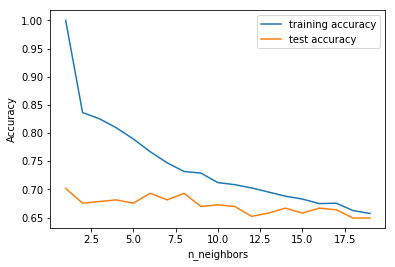

In [10]:
training_accuracy = []
test_accuracy = []
# n_neighbors
neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(trainHMVI, trainHMVL)
    training_accuracy.append(clf.score(trainHMVI, trainHMVL))
    test_accuracy.append(clf.score(testHMVI, testHMVL))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()


# KNN with different color space raw pixels

In [11]:
NeigborsNum = 9

In [12]:
# k-NN BGR
print("[INFO] evaluating BGRImages accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainRI, trainRL)
acc_train = model.score(trainRI, trainRL)
acc_test = model.score(testRI, testRL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] BGR Raw Pixels training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] BGR Raw Pixels test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] BGR Raw Pixels Images k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating BGRImages accuracy...
[INFO] k-NN classifier: k=9
[INFO] BGR Raw Pixels training set accuracy: 35.16%
[INFO] BGR Raw Pixels test set accuracy: 21.64%
[INFO] BGR Raw Pixels Images k-NN classifier complete in 2m 55s


In [13]:
# k-NN HSV
print("[INFO] evaluating HSVImages accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainVI, trainVL)
acc_train = model.score(trainVI, trainVL)
acc_test = model.score(testVI, testVL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HSV Raw Pixels training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV Raw Pixels test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV Raw Pixels Images k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating HSVImages accuracy...
[INFO] k-NN classifier: k=9
[INFO] HSV Raw Pixels training set accuracy: 44.23%
[INFO] HSV Raw Pixels test set accuracy: 37.13%
[INFO] HSV Raw Pixels Images k-NN classifier complete in 2m 54s


In [14]:
# k-NN HLS
print("[INFO] evaluating HLSImages accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainSI, trainSL)
acc_train = model.score(trainSI, trainSL)
acc_test = model.score(testSI, testSL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HLS Raw Pixels training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HLS Raw Pixels test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HLS Raw Pixels Images k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating HLSImages accuracy...
[INFO] k-NN classifier: k=9
[INFO] HLS Raw Pixels training set accuracy: 45.83%
[INFO] HLS Raw Pixels test set accuracy: 37.13%
[INFO] HLS Raw Pixels Images k-NN classifier complete in 2m 53s


# KNN with different color space histograms

In [15]:
# k-NN BGR_hisogram
print("[INFO] evaluating his_BGR accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHBI, trainHBL)
acc_train = model.score(trainHBI, trainHBL)
acc_test = model.score(testHBI, testHBL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] BGR hisograms training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] BGR hisograms test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] BGR hisograms k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating his_BGR accuracy...
[INFO] k-NN classifier: k=9
[INFO] BGR hisograms training set accuracy: 66.52%
[INFO] BGR hisograms test set accuracy: 54.68%
[INFO] BGR hisograms k-NN classifier complete in 0m 1s


In [16]:
# k-NN HSV_hisogram
print("[INFO] evaluating his_HSV accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHVI, trainHVL)
acc_train = model.score(trainHVI, trainHVL)
acc_test = model.score(testHVI, testHVL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HSV hisograms training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV hisograms test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV hisograms k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))


[INFO] evaluating his_HSV accuracy...
[INFO] k-NN classifier: k=9
[INFO] HSV hisograms training set accuracy: 72.59%
[INFO] HSV hisograms test set accuracy: 64.91%
[INFO] HSV hisograms k-NN classifier complete in 0m 1s


In [17]:
# k-NN HLS_hisogram
print("[INFO] evaluating his_HLS accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHSI, trainHSL)
acc_train = model.score(trainHSI, trainHSL)
acc_test = model.score(testHSI, testHSL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HLS hisograms training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HLS hisograms test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HLS hisograms k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating his_HLS accuracy...
[INFO] k-NN classifier: k=9
[INFO] HLS hisograms training set accuracy: 71.20%
[INFO] HLS hisograms test set accuracy: 63.45%
[INFO] HLS hisograms k-NN classifier complete in 0m 1s


# KNN with different color space histograms after masking

In [18]:
# k-NN BGR_hisogram after masking
print("[INFO] evaluating his_msk_BGR accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHMBI, trainHMBL)
acc_train = model.score(trainHMBI, trainHMBL)
acc_test = model.score(testHMBI, testHMBL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] BGR hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] BGR hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] BGR hisograms after masking k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating his_msk_BGR accuracy...
[INFO] k-NN classifier: k=9
[INFO] BGR hisograms after masking training set accuracy: 69.15%
[INFO] BGR hisograms after masking test set accuracy: 61.70%
[INFO] BGR hisograms after masking k-NN classifier complete in 0m 0s


In [19]:
# k-NN HLS_hisogram after masking
print("[INFO] evaluating his_msk_HLS accuracy...")
tic = time.time()

model = KNeighborsClassifier(n_neighbors= NeigborsNum)
model.fit(trainHMSI, trainHMSL)
acc_train = model.score(trainHMSI, trainHMSL)
acc_test = model.score(testHMSI, testHMSL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HLS hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HLS hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HLS hisograms after masking k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating his_msk_HLS accuracy...
[INFO] k-NN classifier: k=9
[INFO] HLS hisograms after masking training set accuracy: 72.22%
[INFO] HLS hisograms after masking test set accuracy: 66.67%
[INFO] HLS hisograms after masking k-NN classifier complete in 0m 0s


In [20]:
# k-NN HSV_hisogram after masking
print("[INFO] evaluating his_msk_HSV accuracy...")
tic = time.time()

modelknn = KNeighborsClassifier(n_neighbors= NeigborsNum)
modelknn.fit(trainHMVI, trainHMVL)
acc_train = modelknn.score(trainHMVI, trainHMVL)
acc_test = modelknn.score(testHMVI, testHMVL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] k-NN classifier: k={}".format(NeigborsNum))
print("[INFO] HSV hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV hisograms after masking k-NN classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

[INFO] evaluating his_msk_HSV accuracy...
[INFO] k-NN classifier: k=9
[INFO] HSV hisograms after masking training set accuracy: 72.88%
[INFO] HSV hisograms after masking test set accuracy: 66.96%
[INFO] HSV hisograms after masking k-NN classifier complete in 0m 0s


# HSV Mask Histograms KNN Model evaluation

In [21]:
# k-NN Mask Histograms classfication report
KnnHSVMaskHis_repo = classification_report(testHMVL, modelknn.predict(testHMVI))
print(KnnHSVMaskHis_repo)

              precision    recall  f1-score   support

           0       0.33      0.15      0.21        20
           1       0.69      0.85      0.76        39
           2       0.83      0.83      0.83        18
           3       0.88      0.82      0.85        55
           4       0.57      0.40      0.47        10
           5       0.69      0.69      0.69        39
           6       0.60      0.75      0.67        40
           7       0.75      0.75      0.75         8
           8       0.59      0.64      0.62        45
           9       0.22      0.14      0.17        14
          10       0.61      0.77      0.68        30
          11       0.75      0.50      0.60        24

   micro avg       0.67      0.67      0.67       342
   macro avg       0.63      0.61      0.61       342
weighted avg       0.66      0.67      0.66       342



In [22]:
# prediction probability of each class
y_scoreknn = modelknn.predict_proba(testHMSI)

# test lables one-hot conversion
testHMVL_onehot = label_binarize(testHMVL, np.arange(12))

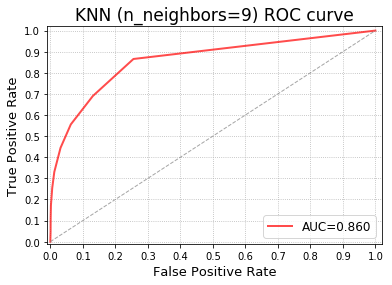

In [23]:
# calculate AUC
fprknn, tprknn, thresholds = metrics.roc_curve(testHMVL_onehot.ravel(),y_scoreknn.ravel())
aucknn = metrics.auc(fprknn, tprknn)

# plot the ROC curve
plt.plot(fprknn, tprknn, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % aucknn)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'KNN (n_neighbors=9) ROC curve', fontsize=17)
plt.show() 

# Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

# random forest HSV_hisogram after masking, default parameters
print("[INFO] evaluating his_msk_HSV accuracy...")
tic = time.time()

rf0 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=27)
rf0.fit(trainHMVI, trainHMVL)
acc_train = rf0.score(trainHMVI, trainHMVL)
acc_test = rf0.score(testHMVI, testHMVL)

toc = time.time()
time_elapsed = toc - tic

print ("[INFO] his_mask_HSV histogram oob_scor: {:.2f}%".format(rf0.oob_score_* 100))
print("[INFO] HSV hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV hisograms after masking RF classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

# AUC
y_predprob = rf0.predict_proba(testHMVI)
print ("AUC Score (test): %f" % metrics.roc_auc_score(testHMVL_onehot, y_predprob))

[INFO] evaluating his_msk_HSV accuracy...
[INFO] his_mask_HSV histogram oob_scor: 79.02%
[INFO] HSV hisograms after masking training set accuracy: 100.00%
[INFO] HSV hisograms after masking test set accuracy: 78.95%
[INFO] HSV hisograms after masking RF classifier complete in 0m 1s
AUC Score (test): 0.984430


# Tuning parameter GridsearchCV

In [25]:
from sklearn.model_selection import GridSearchCV

# gridsearch for the n_estimators
param_test1 = {'n_estimators':range(50,200,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(oob_score=True,random_state=27), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(testHMVI, testHMVL_onehot)
print ("[INFO] gsearch1.best_params_: {}, gsearch1.best_score_: {}".format(gsearch1.best_params_, gsearch1.best_score_))

# gridsearch for max_depth & min_samples_split
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(2,10,2)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 190,oob_score=True, random_state=27),
   param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(testHMVI, testHMVL_onehot)
print ("[INFO] gsearch1.best_params_: {}, gsearch1.best_score_: {}".format(gsearch2.best_params_, gsearch2.best_score_))

# gridsearch for min_samples_split & min_samples_leaf
param_test3 = {'min_samples_split':range(2,10,2), 'min_samples_leaf':range(2,10,2)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 190, max_depth=13, oob_score=True, random_state=27),
   param_grid = param_test3, scoring='roc_auc', cv=5)
gsearch3.fit(testHMVI, testHMVL_onehot)
print ("[INFO] gsearch1.best_params_: {}, gsearch1.best_score_: {}".format(gsearch3.best_params_, gsearch3.best_score_))

# gridsearch for max_features
param_test4 = {'max_features':range(3,60,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 190, max_depth=13, min_samples_split=2,
                                  min_samples_leaf=2 ,oob_score=True, random_state=27),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(testHMVI, testHMVL_onehot)
print ("[INFO] gsearch1.best_params_: {}, gsearch1.best_score_: {}".format(gsearch4.best_params_, gsearch4.best_score_))

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# Reset parameters

In [ ]:
# random forest HSV_hisogram after masking, gridsearch parameters
print("[INFO] evaluating his_msk_HSV accuracy...")
tic = time.time()

rf1 = RandomForestClassifier(n_estimators= 180, max_depth=5, min_samples_split=2,
                                  min_samples_leaf=2, max_features=7, oob_score=True, random_state=27)
rf1.fit(trainHMVI, trainHMVL)
acc_train = rf1.score(trainHMVI, trainHMVL)
acc_test = rf1.score(testHMVI, testHMVL)

toc = time.time()
time_elapsed = toc - tic

print ("[INFO] his_mask_HSV histogram oob_scor: {:.2f}%".format(rf1.oob_score_* 100))
print("[INFO] HSV hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV hisograms after masking RF classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

y_predprob = rf1.predict_proba(testHMVI)
print ("AUC Score (test): %f" % metrics.roc_auc_score(testHMVL_onehot, y_predprob))

# Using default parameters for evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# random forest HSV_hisogram after masking, default parameters
print("[INFO] evaluating his_msk_HSV accuracy...")
tic = time.time()

rf0 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=27)
rf0.fit(trainHMVI, trainHMVL)
acc_train = rf0.score(trainHMVI, trainHMVL)
acc_test = rf0.score(testHMVI, testHMVL)

toc = time.time()
time_elapsed = toc - tic

print ("[INFO] his_mask_HSV histogram oob_scor: {:.2f}%".format(rf0.oob_score_* 100))
print("[INFO] HSV hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV hisograms after masking RF classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

print(classification_report(testHMVL, rf0.predict(testHMVI)))

# prediction probability of each class
y_scorerf0 = rf0.predict_proba(testHMVI)

fprrf0, tprrf0, thresholds = metrics.roc_curve(testHMVL_onehot.ravel(),y_scorerf0.ravel())
aucrf0 = metrics.auc(fprrf0, tprrf0)
#FPR就是横坐标,TPR就是纵坐标
plt.plot(fprrf0, tprrf0, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % aucrf0)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'RF ROC curve', fontsize=17)
plt.show() 

# XGBoost

In [ ]:
from xgboost import XGBClassifier

# XGBoost
params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
                                    
print("[INFO] evaluating HSVImages accuracy...")
tic = time.time()

modelxgb = XGBClassifier(**params)
modelxgb.fit(trainHMVI, trainHMVL)
acc_train = modelxgb.score(trainHMVI, trainHMVL)
acc_test = modelxgb.score(testHMVI, testHMVL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] HSV hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV hisograms after masking RF classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

print(classification_report(testHMVL, modelxgb.predict(testHMVI)))

# prediction probability of each class
y_scorexgb = modelxgb.predict_proba(testHMVI)

fprxgb, tprxgb, thresholds = metrics.roc_curve(testHMVL_onehot.ravel(),y_scorexgb.ravel())
aucxgb = metrics.auc(fprxgb, tprxgb)
#FPR就是横坐标,TPR就是纵坐标
plt.plot(fprxgb, tprxgb, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % aucxgb)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'RF ROC curve', fontsize=17)
plt.show() 


# SVM

In [ ]:
from sklearn.svm import SVC

#SVC
print("[INFO] evaluating histogram accuracy...")
tic = time.time()

modelsvc = SVC(kernel='rbf', gamma='auto', probability=True)
modelsvc.fit(trainHMVI, trainHMVL)
acc_train = modelsvc.score(trainHMVI, trainHMVL)
acc_test = modelsvc.score(testHMVI, testHMVL)

toc = time.time()
time_elapsed = toc - tic

print("[INFO] HSV hisograms after masking training set accuracy: {:.2f}%".format(acc_train * 100))
print("[INFO] HSV hisograms after masking test set accuracy: {:.2f}%".format(acc_test * 100))
print("[INFO] HSV hisograms after masking RF classifier complete in {:.0f}m {:.0f}s".format(
    time_elapsed // 60, time_elapsed % 60))

print(classification_report(testHMVL, modelsvc.predict(testHMVI)))

# prediction probability of each class
y_scoresvc = modelsvc.predict_proba(testHMVI)

fprsvc, tprsvc, thresholds = metrics.roc_curve(testHMVL_onehot.ravel(),y_scoresvc.ravel())
aucsvc = metrics.auc(fprsvc, tprsvc)
#FPR就是横坐标,TPR就是纵坐标
plt.plot(fprsvc, tprsvc, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % aucsvc)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'RF ROC curve', fontsize=17)
plt.show()

# Plot all ROC

In [ ]:
plt.plot(fprknn, tprknn, c = 'b', lw = 2, linestyle='-.', alpha = 0.7, label = u'knnAUC=%.3f' % aucknn)
plt.plot(fprrf0, tprrf0, c = 'g', lw = 2, linestyle='--', alpha = 0.7, label = u'rfAUC=%.3f' % aucrf0)
plt.plot(fprxgb, tprxgb, c = 'r', lw = 2, linestyle=':', alpha = 0.7, label = u'xgbAUC=%.3f' % aucxgb)
plt.plot(fprsvc, tprsvc, c = 'y', lw = 2, linestyle='-', alpha = 0.7, label = u'svcAUC=%.3f' % aucsvc)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)

plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'RF ROC curve', fontsize=17)
plt.show() 